In [2]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt



import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, Activation, Multiply, Add, Lambda, BatchNormalization
from tensorflow.keras import regularizers


module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v11/"

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
BATCH_SIZE = 256
T = 20
VOCAB = ['start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
LATENT_DIM = EMB_DIM = 16
HIDDEN_DIM = 128

## Load Data

In [4]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
#neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')


def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


def load_sequence_from_pickle_to_numpy(pickle_file_path):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
#     print(seqs.shape)
    
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    return et_seqs, ts_seqs
    
pos_event_type_seqs, pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path)
#neg_event_type_seqs, neg_timestamp_seqs = load_sequence_from_pickle_to_numpy(neg_data_path)

In [26]:
def zcore_norm(data):
    N = data.shape[0]
    
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std

pos_timestamp_seqs = zcore_norm(pos_timestamp_seqs)

## Build G and D of RC-GAN

In [27]:
# noise
z = np.float32(np.random.normal(size=[BATCH_SIZE, T, LATENT_DIM]))

In [56]:
def build_G(batch_size, seq_length, latent_dim, hidden_dim=11):
    # normal LSTM
    i_noise = Input(batch_shape=(batch_size, seq_length, latent_dim), name='noise')

    whole_seq_output, final_memory_state, final_carry_state = LSTM(hidden_dim, 
                       name='lstm',
                       stateful=True,
                       return_sequences=True,
                       return_state = True, #from RC-GAN
                       unit_forget_bias=True, #from RC-GAN
                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(i_noise)

    ts = Dense(1,
                   activation='linear',
                   name='dense_1',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(whole_seq_output)    

    generator = Model(
        inputs=i_noise,
        outputs=ts)
    
    return generator

In [57]:
G = build_G(batch_size=BATCH_SIZE, seq_length=T, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM)

In [58]:
# G(z)

In [59]:
def build_D(T, latent_dim, hidden_dim=11):
    i_ts = Input(shape=(T, 1), name='time_stamps')
    
    whole_seq_output, final_memory_state, final_carry_state = LSTM(hidden_dim, 
                       name='lstm',
                       #stateful=True,
                       return_sequences=False,
                       return_state = True, #from RC-GAN
                       unit_forget_bias=True, #from RC-GAN
                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(i_ts)
    

    logits = Dense(1,
                   activation='linear',
                   name='dense_1',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(whole_seq_output)    
    
    prob = tf.math.sigmoid(logits)
    
    discriminator = Model(
        inputs=i_ts,
        outputs=[prob, logits])

    return discriminator

In [60]:
D = build_D(T=T, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM)

## Traning G and D with different noises

In [61]:
def train_generator(generator, discriminator, batch_size, T, latent_dim, mc_size=10, verbose=False,                   
                    optimizer=Adam(lr=0.001), end_token=0, init_token=1):
            
    z = np.float32(np.random.normal(size=[batch_size, T, latent_dim]))
    
    with tf.GradientTape() as tape:                        

        G_sample = generator(z)
        D_fake, D_logit_fake = discriminator(G_sample)

        generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator(real_data_batch, generator, discriminator, batch_size, T, latent_dim, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False):

    # data prep
    real_labels = tf.ones((batch_size, 1))        
    fake_labels = tf.zeros((batch_size, 1))    
    
    z = np.float32(np.random.normal(size=[batch_size, T, latent_dim]))
    fake_data_batch = np.array(generator(z))    
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data = tf.concat([fake_data_batch, real_data_batch], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob, pred_logits = discriminator(total_data)

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [68]:
G = build_G(batch_size=BATCH_SIZE, seq_length=T, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM)

D = build_D(T=T, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM)

In [69]:
N_total_G = pos_timestamp_seqs.shape[0]

EPOCHS = 10
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

train_dataset = create_dataset(pos_timestamp_seqs[:N_total_G,:,:],
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []
average_true_return_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-3)
D_optimizer = Adam(learning_rate=1e-3)

_G_STEPS = 2
_D_STEPS = 1

In [75]:
for time_stamp_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):

    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator(G, D, BATCH_SIZE, T, LATENT_DIM, mc_size=100, verbose=True, optimizer=G_optimizer)
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator(time_stamp_batch, G, D, BATCH_SIZE, T, LATENT_DIM, 
                                                         verbose=True, optimizer=D_optimizer, 
                                                         label_smoothing=True, label_flipping=True)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())
        
    if step % 25 == 0:
        z_test = np.float32(np.random.normal(size=[BATCH_SIZE, T, LATENT_DIM]))
        print(G(z_test))
    
    step += 1

0it [00:00, ?it/s]

Training Step: 156
generator loss:0.6602950096130371
-----------------------
generator loss:0.6472615003585815
-----------------------


1it [00:00,  1.26it/s]

total discriminator loss:0.6663464307785034
average true return:0.551563024520874
-----------------------
Training Step: 157
generator loss:0.6515321135520935
-----------------------
generator loss:0.6349675059318542
-----------------------


2it [00:01,  1.28it/s]

total discriminator loss:0.676726758480072
average true return:0.5547336339950562
-----------------------
Training Step: 158
generator loss:0.6474793553352356
-----------------------
generator loss:0.6250660419464111
-----------------------


3it [00:02,  1.29it/s]

total discriminator loss:0.6931765675544739
average true return:0.5543566942214966
-----------------------
Training Step: 159
generator loss:0.6358388066291809
-----------------------
generator loss:0.605642557144165
-----------------------


4it [00:03,  1.28it/s]

total discriminator loss:0.7141167521476746
average true return:0.5581451654434204
-----------------------
Training Step: 160
generator loss:0.603481650352478
-----------------------
generator loss:0.5779954195022583
-----------------------


5it [00:03,  1.28it/s]

total discriminator loss:0.7448693513870239
average true return:0.5524111986160278
-----------------------
Training Step: 161
generator loss:0.5768793821334839
-----------------------
generator loss:0.5727473497390747
-----------------------


6it [00:04,  1.29it/s]

total discriminator loss:0.7412688732147217
average true return:0.537367045879364
-----------------------
Training Step: 162
generator loss:0.6423933506011963
-----------------------
generator loss:0.6483855247497559
-----------------------


7it [00:05,  1.28it/s]

total discriminator loss:0.723390519618988
average true return:0.5136260986328125
-----------------------
Training Step: 163
generator loss:0.744265615940094
-----------------------
generator loss:0.7142034769058228
-----------------------


8it [00:06,  1.29it/s]

total discriminator loss:0.6950024366378784
average true return:0.4974592328071594
-----------------------
Training Step: 164
generator loss:0.8097947835922241
-----------------------
generator loss:0.7842373847961426
-----------------------


9it [00:07,  1.28it/s]

total discriminator loss:0.6630312204360962
average true return:0.47886547446250916
-----------------------
Training Step: 165
generator loss:0.8629179000854492
-----------------------
generator loss:0.847974419593811
-----------------------


10it [00:07,  1.28it/s]

total discriminator loss:0.6411009430885315
average true return:0.4658600091934204
-----------------------
Training Step: 166
generator loss:0.9092181921005249
-----------------------
generator loss:0.8960906267166138
-----------------------


11it [00:08,  1.28it/s]

total discriminator loss:0.6240195035934448
average true return:0.45811671018600464
-----------------------
Training Step: 167
generator loss:0.9434113502502441
-----------------------
generator loss:0.927687406539917
-----------------------


12it [00:09,  1.27it/s]

total discriminator loss:0.620840311050415
average true return:0.4527445435523987
-----------------------
Training Step: 168
generator loss:0.9604564309120178
-----------------------
generator loss:0.9360886812210083
-----------------------


13it [00:10,  1.27it/s]

total discriminator loss:0.619543194770813
average true return:0.45516419410705566
-----------------------
Training Step: 169
generator loss:0.9481000900268555
-----------------------
generator loss:0.9114775657653809
-----------------------


14it [00:10,  1.28it/s]

total discriminator loss:0.6339778304100037
average true return:0.46315813064575195
-----------------------
Training Step: 170
generator loss:0.8634724617004395
-----------------------
generator loss:0.810192346572876
-----------------------


15it [00:11,  1.28it/s]

total discriminator loss:0.6715795993804932
average true return:0.4920283555984497
-----------------------
Training Step: 171
generator loss:0.7626301646232605
-----------------------
generator loss:0.726202130317688
-----------------------


16it [00:12,  1.28it/s]

total discriminator loss:0.7024590373039246
average true return:0.4991479814052582
-----------------------
Training Step: 172
generator loss:0.708337128162384
-----------------------
generator loss:0.6509435176849365
-----------------------


17it [00:13,  1.27it/s]

total discriminator loss:0.7482093572616577
average true return:0.5198838114738464
-----------------------
Training Step: 173
generator loss:0.5922470688819885
-----------------------
generator loss:0.6036586165428162
-----------------------


18it [00:14,  1.27it/s]

total discriminator loss:0.7269351482391357
average true return:0.525973916053772
-----------------------
Training Step: 174
generator loss:0.6405858993530273
-----------------------
generator loss:0.6374393701553345
-----------------------


19it [00:14,  1.27it/s]

total discriminator loss:0.7219076156616211
average true return:0.533768355846405
-----------------------
Training Step: 175
generator loss:0.6352460384368896
-----------------------
generator loss:0.6173965334892273
-----------------------


20it [00:15,  1.24it/s]

total discriminator loss:0.7134549617767334
average true return:0.5438162684440613
-----------------------
tf.Tensor(
[[[ 0.3376556 ]
  [ 0.6241954 ]
  [ 0.8442815 ]
  ...
  [ 0.5835409 ]
  [ 1.0841209 ]
  [ 1.0517795 ]]

 [[-0.23440759]
  [ 0.03178836]
  [-0.09436929]
  ...
  [-0.41478124]
  [-0.61657816]
  [-0.41041943]]

 [[ 0.48037106]
  [ 0.55010176]
  [ 1.0305364 ]
  ...
  [ 1.0702897 ]
  [ 0.8381728 ]
  [ 0.78244084]]

 ...

 [[ 1.148027  ]
  [ 0.81449026]
  [ 0.7771773 ]
  ...
  [ 0.19966885]
  [-0.10517599]
  [-0.5023575 ]]

 [[-0.05152611]
  [ 0.12042271]
  [ 0.06018132]
  ...
  [ 0.01450223]
  [ 0.14077708]
  [ 0.61162716]]

 [[ 0.49504697]
  [ 0.22465682]
  [ 0.01698178]
  ...
  [-0.19891451]
  [-0.23716293]
  [-0.47983316]]], shape=(256, 20, 1), dtype=float32)
Training Step: 176
generator loss:0.6221936345100403
-----------------------
generator loss:0.5983694195747375
-----------------------


21it [00:16,  1.26it/s]

total discriminator loss:0.7059422731399536
average true return:0.5520758628845215
-----------------------
Training Step: 177
generator loss:0.6157639026641846
-----------------------
generator loss:0.6017558574676514
-----------------------


22it [00:17,  1.27it/s]

total discriminator loss:0.694281816482544
average true return:0.5447320938110352
-----------------------
Training Step: 178
generator loss:0.623241662979126
-----------------------
generator loss:0.6244713068008423
-----------------------


23it [00:18,  1.27it/s]

total discriminator loss:0.6770128011703491
average true return:0.5465831756591797
-----------------------
Training Step: 179
generator loss:0.6454449892044067
-----------------------
generator loss:0.6416452527046204
-----------------------


24it [00:18,  1.28it/s]

total discriminator loss:0.6720141172409058
average true return:0.5397051572799683
-----------------------
Training Step: 180
generator loss:0.6722877621650696
-----------------------
generator loss:0.6687226295471191
-----------------------


25it [00:19,  1.28it/s]

total discriminator loss:0.6648332476615906
average true return:0.529688835144043
-----------------------
Training Step: 181
generator loss:0.7111812233924866
-----------------------
generator loss:0.7075473666191101
-----------------------


26it [00:20,  1.27it/s]

total discriminator loss:0.6571776866912842
average true return:0.5171374082565308
-----------------------
Training Step: 182
generator loss:0.7718617916107178
-----------------------
generator loss:0.7704666256904602
-----------------------


27it [00:21,  1.28it/s]

total discriminator loss:0.643347978591919
average true return:0.4982472360134125
-----------------------
Training Step: 183
generator loss:0.85374915599823
-----------------------
generator loss:0.8529757857322693
-----------------------


28it [00:21,  1.28it/s]

total discriminator loss:0.6265918016433716
average true return:0.4734994173049927
-----------------------
Training Step: 184
generator loss:0.9551318287849426
-----------------------
generator loss:0.9496322870254517
-----------------------


29it [00:22,  1.39it/s]

total discriminator loss:0.8004952669143677
average true return:0.44173604249954224
-----------------------
Training Step: 185
generator loss:0.9915899038314819
-----------------------
generator loss:0.9882853627204895
-----------------------
total discriminator loss:0.6171598434448242
average true return:0.4310970902442932
-----------------------


30it [00:23,  1.50it/s]

Training Step: 186
generator loss:1.019404411315918
-----------------------
generator loss:1.0124752521514893
-----------------------
total discriminator loss:0.6220043897628784
average true return:0.4208143949508667
-----------------------


31it [00:23,  1.60it/s]

Training Step: 187
generator loss:1.0285816192626953
-----------------------
generator loss:1.0214170217514038
-----------------------
total discriminator loss:0.6289424896240234
average true return:0.41386955976486206
-----------------------


32it [00:24,  1.66it/s]

Training Step: 188
generator loss:1.0267245769500732
-----------------------
generator loss:1.0159099102020264
-----------------------
total discriminator loss:0.6252865791320801
average true return:0.4207160472869873
-----------------------


33it [00:24,  1.72it/s]

Training Step: 189
generator loss:1.0083389282226562
-----------------------
generator loss:0.9986264109611511
-----------------------
total discriminator loss:0.6319323778152466
average true return:0.4223787784576416
-----------------------


34it [00:25,  1.76it/s]

Training Step: 190
generator loss:0.9894113540649414
-----------------------
generator loss:0.984153151512146
-----------------------
total discriminator loss:0.6169407963752747
average true return:0.4313116669654846
-----------------------


35it [00:25,  1.79it/s]

Training Step: 191
generator loss:0.9850825071334839
-----------------------
generator loss:0.9818230867385864
-----------------------
total discriminator loss:0.6082244515419006
average true return:0.44352999329566956
-----------------------


36it [00:26,  1.81it/s]

Training Step: 192
generator loss:0.967731237411499
-----------------------
generator loss:0.9506010413169861
-----------------------
total discriminator loss:0.5947753190994263
average true return:0.4726886749267578
-----------------------


37it [00:26,  1.82it/s]

Training Step: 193
generator loss:0.9249465465545654
-----------------------
generator loss:0.8790879249572754
-----------------------
total discriminator loss:0.5982580780982971
average true return:0.5006977319717407
-----------------------


38it [00:27,  1.84it/s]

Training Step: 194
generator loss:0.8729498386383057
-----------------------
generator loss:0.824898898601532
-----------------------
total discriminator loss:0.7981016635894775
average true return:0.5245550870895386
-----------------------


39it [00:27,  1.84it/s]

Training Step: 195
generator loss:0.6881719827651978
-----------------------
generator loss:0.6559872627258301
-----------------------
total discriminator loss:0.6762140989303589
average true return:0.5772093534469604
-----------------------


40it [00:28,  1.85it/s]

Training Step: 196
generator loss:0.5769821405410767
-----------------------
generator loss:0.5474213361740112
-----------------------
total discriminator loss:0.6936371922492981
average true return:0.6045254468917847
-----------------------


41it [00:28,  1.85it/s]

Training Step: 197
generator loss:0.5138238668441772
-----------------------
generator loss:0.509363055229187
-----------------------
total discriminator loss:0.7147755026817322
average true return:0.6099110841751099
-----------------------


42it [00:29,  1.86it/s]

Training Step: 198
generator loss:0.49651262164115906
-----------------------
generator loss:0.4918897747993469
-----------------------
total discriminator loss:0.7252969741821289
average true return:0.6222056746482849
-----------------------


43it [00:30,  1.86it/s]

Training Step: 199
generator loss:0.4945434629917145
-----------------------
generator loss:0.48440980911254883
-----------------------
total discriminator loss:0.7290016412734985
average true return:0.6245955228805542
-----------------------


44it [00:30,  1.86it/s]

Training Step: 200
generator loss:0.49245211482048035
-----------------------
generator loss:0.47375941276550293
-----------------------
total discriminator loss:0.7377181053161621
average true return:0.6281789541244507
-----------------------


45it [00:31,  1.80it/s]

tf.Tensor(
[[[ 1.8006684 ]
  [ 1.2371316 ]
  [ 0.05951097]
  ...
  [-1.2673166 ]
  [-0.83620083]
  [ 0.00843657]]

 [[-0.40627804]
  [ 0.20367372]
  [ 0.96890247]
  ...
  [ 0.3370628 ]
  [-0.18393618]
  [-1.3174517 ]]

 [[-2.0606787 ]
  [-0.59186625]
  [-0.33047506]
  ...
  [ 1.901452  ]
  [ 1.2164487 ]
  [ 0.5630618 ]]

 ...

 [[ 1.5193498 ]
  [ 1.6395926 ]
  [ 1.4102911 ]
  ...
  [-1.2908247 ]
  [-1.3794427 ]
  [-0.39207852]]

 [[-1.2362654 ]
  [-2.4388826 ]
  [-2.618333  ]
  ...
  [ 1.3089952 ]
  [ 0.6829723 ]
  [ 1.0459856 ]]

 [[ 1.1444352 ]
  [-0.33303326]
  [ 0.7559107 ]
  ...
  [ 0.26649544]
  [ 1.8489605 ]
  [ 1.7059437 ]]], shape=(256, 20, 1), dtype=float32)
Training Step: 201
generator loss:0.4831353425979614
-----------------------
generator loss:0.46671316027641296
-----------------------
total discriminator loss:0.7478712797164917
average true return:0.6293073892593384
-----------------------


46it [00:31,  1.82it/s]

Training Step: 202
generator loss:0.4868249297142029
-----------------------
generator loss:0.473025381565094
-----------------------
total discriminator loss:0.7398674488067627
average true return:0.6242653131484985
-----------------------


47it [00:32,  1.83it/s]

Training Step: 203
generator loss:0.5036780834197998
-----------------------
generator loss:0.49655017256736755
-----------------------
total discriminator loss:0.7302408218383789
average true return:0.6128913760185242
-----------------------


48it [00:32,  1.84it/s]

Training Step: 204
generator loss:0.5312491655349731
-----------------------
generator loss:0.5266697406768799
-----------------------
total discriminator loss:0.7208912372589111
average true return:0.5903965830802917
-----------------------


49it [00:33,  1.84it/s]

Training Step: 205
generator loss:0.5679432153701782
-----------------------
generator loss:0.5614473819732666
-----------------------
total discriminator loss:0.7120763659477234
average true return:0.5706928968429565
-----------------------


50it [00:33,  1.85it/s]

Training Step: 206
generator loss:0.6138187050819397
-----------------------
generator loss:0.6148136854171753
-----------------------
total discriminator loss:0.7090091109275818
average true return:0.5425351858139038
-----------------------


51it [00:34,  1.86it/s]

Training Step: 207
generator loss:0.6631286144256592
-----------------------
generator loss:0.6590092182159424
-----------------------
total discriminator loss:0.7060644030570984
average true return:0.517072319984436
-----------------------


52it [00:34,  1.86it/s]

Training Step: 208
generator loss:0.7131326198577881
-----------------------
generator loss:0.7073441743850708
-----------------------
total discriminator loss:0.7010635733604431
average true return:0.49560242891311646
-----------------------


53it [00:35,  1.86it/s]

Training Step: 209
generator loss:0.7524310350418091
-----------------------
generator loss:0.737271785736084
-----------------------
total discriminator loss:0.7056244015693665
average true return:0.47800761461257935
-----------------------


54it [00:36,  1.86it/s]

Training Step: 210
generator loss:0.7737144231796265
-----------------------
generator loss:0.7651898860931396
-----------------------
total discriminator loss:0.7024399042129517
average true return:0.46565091609954834
-----------------------


55it [00:36,  1.86it/s]

Training Step: 211
generator loss:0.7990453243255615
-----------------------
generator loss:0.7811498045921326
-----------------------
total discriminator loss:0.7082129120826721
average true return:0.4560433328151703
-----------------------


56it [00:37,  1.86it/s]

Training Step: 212
generator loss:0.8057054281234741
-----------------------
generator loss:0.7954265475273132
-----------------------
total discriminator loss:0.7098912596702576
average true return:0.4526105523109436
-----------------------


57it [00:37,  1.85it/s]

Training Step: 213
generator loss:0.7983220815658569
-----------------------
generator loss:0.7909384369850159
-----------------------
total discriminator loss:0.718093991279602
average true return:0.4498896598815918
-----------------------


58it [00:38,  1.86it/s]

Training Step: 214
generator loss:0.7839403748512268
-----------------------
generator loss:0.7774686813354492
-----------------------
total discriminator loss:0.7201985716819763
average true return:0.4521436095237732
-----------------------


59it [00:38,  1.86it/s]

Training Step: 215
generator loss:0.7664763927459717
-----------------------
generator loss:0.7577860355377197
-----------------------
total discriminator loss:0.7280846834182739
average true return:0.4551117420196533
-----------------------


60it [00:39,  1.86it/s]

Training Step: 216
generator loss:0.7448417544364929
-----------------------
generator loss:0.742048978805542
-----------------------
total discriminator loss:0.7274847626686096
average true return:0.4609103202819824
-----------------------


61it [00:39,  1.86it/s]

Training Step: 217
generator loss:0.7238434553146362
-----------------------
generator loss:0.7254729270935059
-----------------------
total discriminator loss:0.7257195711135864
average true return:0.46677884459495544
-----------------------


62it [00:40,  1.87it/s]

Training Step: 218
generator loss:0.7145302295684814
-----------------------
generator loss:0.7121705412864685
-----------------------
total discriminator loss:0.7203824520111084
average true return:0.47355812788009644
-----------------------


63it [00:40,  1.86it/s]

Training Step: 219
generator loss:0.7027868032455444
-----------------------
generator loss:0.7021732926368713
-----------------------
total discriminator loss:0.7161967754364014
average true return:0.48283469676971436
-----------------------


64it [00:41,  1.85it/s]

Training Step: 220
generator loss:0.690669059753418
-----------------------
generator loss:0.6905075907707214
-----------------------
total discriminator loss:0.7116942405700684
average true return:0.49189817905426025
-----------------------


65it [00:41,  1.85it/s]

Training Step: 221
generator loss:0.6784054040908813
-----------------------
generator loss:0.6768314242362976
-----------------------
total discriminator loss:0.7064614295959473
average true return:0.5019083023071289
-----------------------


66it [00:42,  1.85it/s]

Training Step: 222
generator loss:0.6661561727523804
-----------------------
generator loss:0.662224292755127
-----------------------
total discriminator loss:0.7006335258483887
average true return:0.5112674832344055
-----------------------


67it [00:43,  1.85it/s]

Training Step: 223
generator loss:0.652411699295044
-----------------------
generator loss:0.6522477865219116
-----------------------
total discriminator loss:0.6975017189979553
average true return:0.5201601982116699
-----------------------


68it [00:43,  1.85it/s]

Training Step: 224
generator loss:0.6419382691383362
-----------------------
generator loss:0.6398181319236755
-----------------------
total discriminator loss:0.6944459676742554
average true return:0.5276279449462891
-----------------------


69it [00:44,  1.85it/s]

Training Step: 225
generator loss:0.6326079368591309
-----------------------
generator loss:0.6313729286193848
-----------------------
total discriminator loss:0.691862940788269
average true return:0.5344061851501465
-----------------------


70it [00:44,  1.81it/s]

tf.Tensor(
[[[ 0.37015823]
  [ 0.4818234 ]
  [ 0.6887095 ]
  ...
  [-0.1181533 ]
  [ 0.0366472 ]
  [ 0.64194936]]

 [[-0.49930924]
  [-0.612866  ]
  [-0.4356804 ]
  ...
  [-0.20591184]
  [ 0.36652333]
  [ 0.40833482]]

 [[-0.98360497]
  [-0.58066577]
  [-0.34594986]
  ...
  [ 0.26130608]
  [-0.20893842]
  [-1.1813693 ]]

 ...

 [[ 0.03751092]
  [ 0.1860798 ]
  [ 0.12206884]
  ...
  [-0.674225  ]
  [ 0.4746156 ]
  [-0.5000136 ]]

 [[ 0.14976162]
  [-0.4003035 ]
  [-0.26680386]
  ...
  [-0.25181028]
  [ 0.23971683]
  [ 0.503265  ]]

 [[-0.04794685]
  [-0.92356956]
  [-0.92511356]
  ...
  [ 0.6383536 ]
  [-0.01610339]
  [ 0.15058538]]], shape=(256, 20, 1), dtype=float32)
Training Step: 226
generator loss:0.6238602995872498
-----------------------
generator loss:0.6231057643890381
-----------------------
total discriminator loss:0.7029780149459839
average true return:0.5403158664703369
-----------------------


71it [00:45,  1.82it/s]

Training Step: 227
generator loss:0.6192581653594971
-----------------------
generator loss:0.6182922124862671
-----------------------
total discriminator loss:0.691394031047821
average true return:0.5434154272079468
-----------------------


72it [00:45,  1.83it/s]

Training Step: 228
generator loss:0.6142120361328125
-----------------------
generator loss:0.6125689744949341
-----------------------
total discriminator loss:0.6912108659744263
average true return:0.5459648370742798
-----------------------


73it [00:46,  1.84it/s]

Training Step: 229
generator loss:0.6099624037742615
-----------------------
generator loss:0.6099604368209839
-----------------------
total discriminator loss:0.6897834539413452
average true return:0.5483372807502747
-----------------------


74it [00:46,  1.85it/s]

Training Step: 230
generator loss:0.6092150211334229
-----------------------
generator loss:0.6101014614105225
-----------------------
total discriminator loss:0.6904309391975403
average true return:0.5490003824234009
-----------------------


75it [00:47,  1.86it/s]

Training Step: 231
generator loss:0.6092382669448853
-----------------------
generator loss:0.6085996627807617
-----------------------
total discriminator loss:0.6907563209533691
average true return:0.5486643314361572
-----------------------


76it [00:47,  1.86it/s]

Training Step: 232
generator loss:0.6110826730728149
-----------------------
generator loss:0.6092482805252075
-----------------------
total discriminator loss:0.6902446746826172
average true return:0.548609733581543
-----------------------


77it [00:48,  1.86it/s]

Training Step: 233
generator loss:0.6144914031028748
-----------------------
generator loss:0.612417459487915
-----------------------
total discriminator loss:0.689752459526062
average true return:0.5474810600280762
-----------------------


78it [00:48,  1.86it/s]

Training Step: 234
generator loss:0.6170492768287659
-----------------------
generator loss:0.6158351898193359
-----------------------
total discriminator loss:0.6920462846755981
average true return:0.5457141995429993
-----------------------


79it [00:49,  1.86it/s]

Training Step: 235
generator loss:0.6217817068099976
-----------------------
generator loss:0.6188786625862122
-----------------------
total discriminator loss:0.690335750579834
average true return:0.5419671535491943
-----------------------


80it [00:50,  1.86it/s]

Training Step: 236
generator loss:0.6255656480789185
-----------------------
generator loss:0.6254146099090576
-----------------------
total discriminator loss:0.691024899482727
average true return:0.5389716029167175
-----------------------


81it [00:50,  1.86it/s]

Training Step: 237
generator loss:0.6302147507667542
-----------------------
generator loss:0.6299620866775513
-----------------------
total discriminator loss:0.6899626851081848
average true return:0.536737859249115
-----------------------


82it [00:51,  1.86it/s]

Training Step: 238
generator loss:0.6368044018745422
-----------------------
generator loss:0.6339317560195923
-----------------------
total discriminator loss:0.6903289556503296
average true return:0.5335344672203064
-----------------------


83it [00:51,  1.85it/s]

Training Step: 239
generator loss:0.6408309936523438
-----------------------
generator loss:0.6398523449897766
-----------------------
total discriminator loss:0.6933771371841431
average true return:0.5291506052017212
-----------------------


84it [00:52,  1.85it/s]

Training Step: 240
generator loss:0.6463279724121094
-----------------------
generator loss:0.6472315788269043
-----------------------
total discriminator loss:0.6927451491355896
average true return:0.5258355140686035
-----------------------


85it [00:52,  1.85it/s]

Training Step: 241
generator loss:0.6529526710510254
-----------------------
generator loss:0.6523895859718323
-----------------------
total discriminator loss:0.6913072466850281
average true return:0.522997260093689
-----------------------


86it [00:53,  1.86it/s]

Training Step: 242
generator loss:0.6596975326538086
-----------------------
generator loss:0.6595107316970825
-----------------------
total discriminator loss:0.6930311918258667
average true return:0.5192323923110962
-----------------------


87it [00:53,  1.85it/s]

Training Step: 243
generator loss:0.6674052476882935
-----------------------
generator loss:0.6666405200958252
-----------------------
total discriminator loss:0.6922175884246826
average true return:0.5153643488883972
-----------------------


88it [00:54,  1.85it/s]

Training Step: 244
generator loss:0.6769281625747681
-----------------------
generator loss:0.6747120022773743
-----------------------


89it [00:54,  1.82it/s]

total discriminator loss:0.6895995736122131
average true return:0.5129736661911011
-----------------------
Training Step: 245
generator loss:0.6850675940513611
-----------------------
generator loss:0.684600830078125
-----------------------
total discriminator loss:0.6879473924636841
average true return:0.5081726312637329
-----------------------


90it [00:55,  1.83it/s]

Training Step: 246
generator loss:0.6966888904571533
-----------------------
generator loss:0.6960920095443726
-----------------------
total discriminator loss:0.6851476430892944
average true return:0.5050525665283203
-----------------------


91it [00:56,  1.84it/s]

Training Step: 247
generator loss:0.7090719938278198
-----------------------
generator loss:0.7064404487609863
-----------------------
total discriminator loss:0.6817076206207275
average true return:0.500993013381958
-----------------------


92it [00:56,  1.85it/s]

Training Step: 248
generator loss:0.7204928398132324
-----------------------
generator loss:0.7199780941009521
-----------------------
total discriminator loss:0.6781011819839478
average true return:0.49687761068344116
-----------------------


93it [00:57,  1.85it/s]

Training Step: 249
generator loss:0.7350422143936157
-----------------------
generator loss:0.7342603206634521
-----------------------
total discriminator loss:0.6768848896026611
average true return:0.4913386106491089
-----------------------


94it [00:57,  1.85it/s]

Training Step: 250
generator loss:0.7509867548942566
-----------------------
generator loss:0.7491476535797119
-----------------------
total discriminator loss:0.6718558073043823
average true return:0.4881505072116852
-----------------------


95it [00:58,  1.80it/s]

tf.Tensor(
[[[-0.18932597]
  [ 0.29277802]
  [-0.9339556 ]
  ...
  [ 0.68513113]
  [ 0.29622987]
  [-0.03143039]]

 [[-0.71197486]
  [-1.9613118 ]
  [-1.3744198 ]
  ...
  [ 0.68671775]
  [-1.4083267 ]
  [-1.9011018 ]]

 [[-1.716893  ]
  [-1.2609539 ]
  [ 0.10644799]
  ...
  [-1.0355414 ]
  [-1.0263164 ]
  [ 0.14393741]]

 ...

 [[-0.10919896]
  [-1.2609681 ]
  [-1.3712518 ]
  ...
  [ 0.50398225]
  [-1.2368151 ]
  [-0.04495   ]]

 [[-0.5178119 ]
  [-0.5388518 ]
  [-0.48219776]
  ...
  [-0.61101466]
  [ 0.69534177]
  [-0.19447361]]

 [[ 0.67873806]
  [-0.04730171]
  [-0.47767282]
  ...
  [ 0.85017556]
  [-0.80859333]
  [-0.95936316]]], shape=(256, 20, 1), dtype=float32)
Training Step: 251
generator loss:0.7681466341018677
-----------------------
generator loss:0.7599506378173828
-----------------------
total discriminator loss:0.670042872428894
average true return:0.48325687646865845
-----------------------


96it [00:58,  1.82it/s]

Training Step: 252
generator loss:0.7807233333587646
-----------------------
generator loss:0.774775505065918
-----------------------
total discriminator loss:0.671196460723877
average true return:0.4805285334587097
-----------------------


97it [00:59,  1.83it/s]

Training Step: 253
generator loss:0.7849008440971375
-----------------------
generator loss:0.7787047624588013
-----------------------
total discriminator loss:0.6727071404457092
average true return:0.4776546359062195
-----------------------


98it [00:59,  1.84it/s]

Training Step: 254
generator loss:0.7859834432601929
-----------------------
generator loss:0.7806240320205688
-----------------------
total discriminator loss:0.6776587963104248
average true return:0.47645750641822815
-----------------------


99it [01:00,  1.84it/s]

Training Step: 255
generator loss:0.7798311114311218
-----------------------
generator loss:0.7703823447227478
-----------------------
total discriminator loss:0.7114943265914917
average true return:0.4790906608104706
-----------------------


100it [01:00,  1.85it/s]

Training Step: 256
generator loss:0.7602533102035522
-----------------------
generator loss:0.7393994331359863
-----------------------
total discriminator loss:0.6941959261894226
average true return:0.4834097623825073
-----------------------


101it [01:01,  1.85it/s]

Training Step: 257
generator loss:0.7318894863128662
-----------------------
generator loss:0.7086519002914429
-----------------------
total discriminator loss:0.7144712209701538
average true return:0.4924003779888153
-----------------------


102it [01:01,  1.85it/s]

Training Step: 258
generator loss:0.6798704266548157
-----------------------
generator loss:0.654939591884613
-----------------------
total discriminator loss:0.7352198362350464
average true return:0.5065991282463074
-----------------------


103it [01:02,  1.85it/s]

Training Step: 259
generator loss:0.6313149929046631
-----------------------
generator loss:0.6113871335983276
-----------------------
total discriminator loss:0.752302348613739
average true return:0.5233442783355713
-----------------------


104it [01:03,  1.86it/s]

Training Step: 260
generator loss:0.5817180275917053
-----------------------
generator loss:0.5639432668685913
-----------------------
total discriminator loss:0.7775987982749939
average true return:0.5356006622314453
-----------------------


105it [01:03,  1.86it/s]

Training Step: 261
generator loss:0.5502057671546936
-----------------------
generator loss:0.5415937900543213
-----------------------
total discriminator loss:0.7791401743888855
average true return:0.5406398773193359
-----------------------


106it [01:04,  1.86it/s]

Training Step: 262
generator loss:0.5413212776184082
-----------------------
generator loss:0.540076732635498
-----------------------
total discriminator loss:0.77811598777771
average true return:0.5447342395782471
-----------------------


107it [01:04,  1.86it/s]

Training Step: 263
generator loss:0.558644711971283
-----------------------
generator loss:0.5457911491394043
-----------------------
total discriminator loss:0.7706356644630432
average true return:0.5462350845336914
-----------------------


108it [01:05,  1.86it/s]

Training Step: 264
generator loss:0.5633093118667603
-----------------------
generator loss:0.5579737424850464
-----------------------
total discriminator loss:0.7591625452041626
average true return:0.5462126135826111
-----------------------


109it [01:05,  1.86it/s]

Training Step: 265
generator loss:0.5800590515136719
-----------------------
generator loss:0.569917619228363
-----------------------
total discriminator loss:0.7483501434326172
average true return:0.5417453050613403
-----------------------


110it [01:06,  1.86it/s]

Training Step: 266
generator loss:0.5982682704925537
-----------------------
generator loss:0.5945420861244202
-----------------------
total discriminator loss:0.7364214658737183
average true return:0.5327915549278259
-----------------------


111it [01:06,  1.86it/s]

Training Step: 267
generator loss:0.6196956634521484
-----------------------
generator loss:0.6123789548873901
-----------------------
total discriminator loss:0.7262187004089355
average true return:0.5260723233222961
-----------------------


112it [01:07,  1.86it/s]

Training Step: 268
generator loss:0.6410102844238281
-----------------------
generator loss:0.6422706842422485
-----------------------
total discriminator loss:0.7178983688354492
average true return:0.5171184539794922
-----------------------


113it [01:07,  1.86it/s]

Training Step: 269
generator loss:0.6624216437339783
-----------------------
generator loss:0.661189079284668
-----------------------
total discriminator loss:0.7088140249252319
average true return:0.5086554288864136
-----------------------


114it [01:08,  1.86it/s]

Training Step: 270
generator loss:0.6915647387504578
-----------------------
generator loss:0.6863191723823547
-----------------------
total discriminator loss:0.7037299871444702
average true return:0.5011413097381592
-----------------------


115it [01:08,  1.86it/s]

Training Step: 271
generator loss:0.7106996178627014
-----------------------
generator loss:0.6998403072357178
-----------------------
total discriminator loss:0.7019945383071899
average true return:0.4931941032409668
-----------------------


116it [01:09,  1.86it/s]

Training Step: 272
generator loss:0.7239161133766174
-----------------------
generator loss:0.7187695503234863
-----------------------
total discriminator loss:0.6967490911483765
average true return:0.48583853244781494
-----------------------


117it [01:10,  1.86it/s]

Training Step: 273
generator loss:0.7407982349395752
-----------------------
generator loss:0.7359910011291504
-----------------------
total discriminator loss:0.693938672542572
average true return:0.47892436385154724
-----------------------


118it [01:10,  1.85it/s]

Training Step: 274
generator loss:0.7568225860595703
-----------------------
generator loss:0.7481479048728943
-----------------------
total discriminator loss:0.6921365261077881
average true return:0.4732215106487274
-----------------------


119it [01:11,  1.85it/s]

Training Step: 275
generator loss:0.7650746703147888
-----------------------
generator loss:0.7633482217788696
-----------------------
total discriminator loss:0.691946268081665
average true return:0.46806275844573975
-----------------------


120it [01:11,  1.80it/s]

tf.Tensor(
[[[-3.3965838 ]
  [ 1.4686966 ]
  [ 4.7893806 ]
  ...
  [-2.443118  ]
  [-5.104732  ]
  [-3.146996  ]]

 [[-3.8513577 ]
  [-3.2950783 ]
  [-0.39082348]
  ...
  [ 0.31084466]
  [-2.7262714 ]
  [-5.016557  ]]

 [[ 0.43812534]
  [-1.0077046 ]
  [-4.4216776 ]
  ...
  [ 0.75882435]
  [-3.8087595 ]
  [-2.9173245 ]]

 ...

 [[ 1.9459212 ]
  [ 4.5218763 ]
  [ 1.8893838 ]
  ...
  [-3.436261  ]
  [-3.195536  ]
  [ 2.2931492 ]]

 [[ 0.9013462 ]
  [ 2.8872848 ]
  [ 3.031026  ]
  ...
  [ 1.7518831 ]
  [ 4.48886   ]
  [ 2.208271  ]]

 [[-0.63723135]
  [ 3.5452497 ]
  [ 2.5337205 ]
  ...
  [-1.7922184 ]
  [-2.1917589 ]
  [ 2.8239098 ]]], shape=(256, 20, 1), dtype=float32)
Training Step: 276
generator loss:0.7775355577468872
-----------------------
generator loss:0.7767307758331299
-----------------------
total discriminator loss:0.7031530737876892
average true return:0.4636712074279785
-----------------------


121it [01:12,  1.82it/s]

Training Step: 277
generator loss:0.7823238372802734
-----------------------
generator loss:0.7844290733337402
-----------------------
total discriminator loss:0.691979169845581
average true return:0.46306848526000977
-----------------------


122it [01:12,  1.83it/s]

Training Step: 278
generator loss:0.7917742729187012
-----------------------
generator loss:0.7895947694778442
-----------------------


123it [01:13,  1.72it/s]

total discriminator loss:0.6866869926452637
average true return:0.45990610122680664
-----------------------
Training Step: 279
generator loss:0.7912445068359375
-----------------------
generator loss:0.7873528599739075
-----------------------
total discriminator loss:0.6885465383529663
average true return:0.4581912159919739
-----------------------


124it [01:13,  1.76it/s]

Training Step: 280
generator loss:0.8013595342636108
-----------------------
generator loss:0.7975761890411377
-----------------------
total discriminator loss:0.687763512134552
average true return:0.4582134485244751
-----------------------


125it [01:14,  1.79it/s]

Training Step: 281
generator loss:0.7990914583206177
-----------------------
generator loss:0.7985717058181763
-----------------------
total discriminator loss:0.6872323751449585
average true return:0.45958247780799866
-----------------------


126it [01:15,  1.80it/s]

Training Step: 282
generator loss:0.8008115291595459
-----------------------
generator loss:0.8005278706550598
-----------------------
total discriminator loss:0.681415319442749
average true return:0.4618661403656006
-----------------------


127it [01:15,  1.82it/s]

Training Step: 283
generator loss:0.7958983182907104
-----------------------
generator loss:0.7899273037910461
-----------------------
total discriminator loss:0.6800627708435059
average true return:0.4655325412750244
-----------------------


128it [01:16,  1.83it/s]

Training Step: 284
generator loss:0.7822598218917847
-----------------------
generator loss:0.7792620062828064
-----------------------
total discriminator loss:0.6797740459442139
average true return:0.4713553786277771
-----------------------


129it [01:16,  1.84it/s]

Training Step: 285
generator loss:0.7692050933837891
-----------------------
generator loss:0.7642951607704163
-----------------------
total discriminator loss:0.6813266277313232
average true return:0.47716841101646423
-----------------------


130it [01:17,  1.85it/s]

Training Step: 286
generator loss:0.7519457340240479
-----------------------
generator loss:0.7443666458129883
-----------------------
total discriminator loss:0.6832979321479797
average true return:0.4844158887863159
-----------------------


131it [01:17,  1.84it/s]

Training Step: 287
generator loss:0.7303111553192139
-----------------------
generator loss:0.7217315435409546
-----------------------
total discriminator loss:0.6892279386520386
average true return:0.492353618144989
-----------------------


132it [01:18,  1.85it/s]

Training Step: 288
generator loss:0.7103971242904663
-----------------------
generator loss:0.7023333311080933
-----------------------
total discriminator loss:0.6916599273681641
average true return:0.4990171194076538
-----------------------


133it [01:18,  1.85it/s]

Training Step: 289
generator loss:0.6894726753234863
-----------------------
generator loss:0.6826537251472473
-----------------------
total discriminator loss:0.6984672546386719
average true return:0.5052326321601868
-----------------------


134it [01:19,  1.85it/s]

Training Step: 290
generator loss:0.6693434715270996
-----------------------
generator loss:0.6661373376846313
-----------------------
total discriminator loss:0.7006022930145264
average true return:0.5117346048355103
-----------------------


135it [01:19,  1.85it/s]

Training Step: 291
generator loss:0.6529102921485901
-----------------------
generator loss:0.6520571708679199
-----------------------
total discriminator loss:0.7037217020988464
average true return:0.5166923403739929
-----------------------


136it [01:20,  1.85it/s]

Training Step: 292
generator loss:0.6426900625228882
-----------------------
generator loss:0.6407833099365234
-----------------------
total discriminator loss:0.7053393125534058
average true return:0.5211900472640991
-----------------------


137it [01:21,  1.85it/s]

Training Step: 293
generator loss:0.6335421204566956
-----------------------
generator loss:0.6320186853408813
-----------------------
total discriminator loss:0.7091771364212036
average true return:0.5234800577163696
-----------------------


138it [01:21,  1.85it/s]

Training Step: 294
generator loss:0.6264091730117798
-----------------------
generator loss:0.6263419985771179
-----------------------
total discriminator loss:0.7089430689811707
average true return:0.5269918441772461
-----------------------


139it [01:22,  1.85it/s]

Training Step: 295
generator loss:0.6213780045509338
-----------------------
generator loss:0.6215255260467529
-----------------------
total discriminator loss:0.7073379755020142
average true return:0.5292872190475464
-----------------------


140it [01:22,  1.86it/s]

Training Step: 296
generator loss:0.6176798939704895
-----------------------
generator loss:0.616679310798645
-----------------------
total discriminator loss:0.7086489200592041
average true return:0.5324044227600098
-----------------------


141it [01:23,  1.85it/s]

Training Step: 297
generator loss:0.6139100790023804
-----------------------
generator loss:0.6135268211364746
-----------------------
total discriminator loss:0.7079540491104126
average true return:0.5348128080368042
-----------------------


142it [01:23,  1.85it/s]

Training Step: 298
generator loss:0.6118932962417603
-----------------------
generator loss:0.6115075349807739
-----------------------
total discriminator loss:0.7065485715866089
average true return:0.5356870889663696
-----------------------


143it [01:24,  1.85it/s]

Training Step: 299
generator loss:0.610087513923645
-----------------------
generator loss:0.6101927161216736
-----------------------
total discriminator loss:0.7050454616546631
average true return:0.537850022315979
-----------------------


144it [01:24,  1.85it/s]

Training Step: 300
generator loss:0.6094805598258972
-----------------------
generator loss:0.6089171171188354
-----------------------
total discriminator loss:0.7039572596549988
average true return:0.538518488407135
-----------------------


145it [01:25,  1.80it/s]

tf.Tensor(
[[[-0.22161731]
  [ 0.2877971 ]
  [ 0.05452804]
  ...
  [-0.09162721]
  [-0.03605308]
  [-0.00233762]]

 [[-0.07201891]
  [-0.03433861]
  [ 0.05155338]
  ...
  [-0.17576957]
  [-0.21102361]
  [-0.09965365]]

 [[ 0.16268347]
  [ 0.10582097]
  [ 0.32619214]
  ...
  [-0.04390709]
  [ 0.25842667]
  [-0.17102446]]

 ...

 [[ 0.00528155]
  [ 0.23188198]
  [ 0.00296743]
  ...
  [ 0.13255388]
  [-0.0745766 ]
  [ 0.17748262]]

 [[-0.2027755 ]
  [-0.04517688]
  [ 0.01039531]
  ...
  [ 0.14076324]
  [ 0.00525011]
  [-0.12838437]]

 [[ 0.20023854]
  [ 0.2491257 ]
  [-0.14237353]
  ...
  [-0.05985455]
  [ 0.13384165]
  [ 0.16588487]]], shape=(256, 20, 1), dtype=float32)
Training Step: 301
generator loss:0.6084296703338623
-----------------------
generator loss:0.6084616780281067
-----------------------
total discriminator loss:0.7027194499969482
average true return:0.539893627166748
-----------------------


146it [01:25,  1.82it/s]

Training Step: 302
generator loss:0.6077215671539307
-----------------------
generator loss:0.6077998876571655
-----------------------
total discriminator loss:0.7024787664413452
average true return:0.5404672622680664
-----------------------


147it [01:26,  1.83it/s]

Training Step: 303
generator loss:0.6080191135406494
-----------------------
generator loss:0.6084325313568115
-----------------------
total discriminator loss:0.6907622814178467
average true return:0.5410100221633911
-----------------------


148it [01:27,  1.83it/s]

Training Step: 304
generator loss:0.6100937128067017
-----------------------
generator loss:0.6098950505256653
-----------------------
total discriminator loss:0.700782299041748
average true return:0.5402144193649292
-----------------------


149it [01:27,  1.84it/s]

Training Step: 305
generator loss:0.6117665767669678
-----------------------
generator loss:0.6118552088737488
-----------------------
total discriminator loss:0.7002283930778503
average true return:0.5399320125579834
-----------------------


150it [01:28,  1.84it/s]

Training Step: 306
generator loss:0.6141598224639893
-----------------------
generator loss:0.613976001739502
-----------------------
total discriminator loss:0.698652446269989
average true return:0.5395588874816895
-----------------------


151it [01:28,  1.85it/s]

Training Step: 307
generator loss:0.6163414716720581
-----------------------
generator loss:0.6162546873092651
-----------------------
total discriminator loss:0.6998095512390137
average true return:0.538272500038147
-----------------------


152it [01:29,  1.85it/s]

Training Step: 308
generator loss:0.6190191507339478
-----------------------
generator loss:0.6188233494758606
-----------------------
total discriminator loss:0.6981391906738281
average true return:0.5374376773834229
-----------------------


153it [01:29,  1.85it/s]

Training Step: 309
generator loss:0.6219332218170166
-----------------------
generator loss:0.6217393279075623
-----------------------
total discriminator loss:0.6983031034469604
average true return:0.5356568098068237
-----------------------


154it [01:30,  1.85it/s]

Training Step: 310
generator loss:0.6251586675643921
-----------------------
generator loss:0.6249851584434509
-----------------------
total discriminator loss:0.6962279677391052
average true return:0.534417986869812
-----------------------


155it [01:30,  1.85it/s]

Training Step: 311
generator loss:0.6281067132949829
-----------------------
generator loss:0.6281557679176331
-----------------------
total discriminator loss:0.6951757669448853
average true return:0.5332434773445129
-----------------------


156it [01:31,  1.71it/s]


Text(0.5, 0, 'training steps')

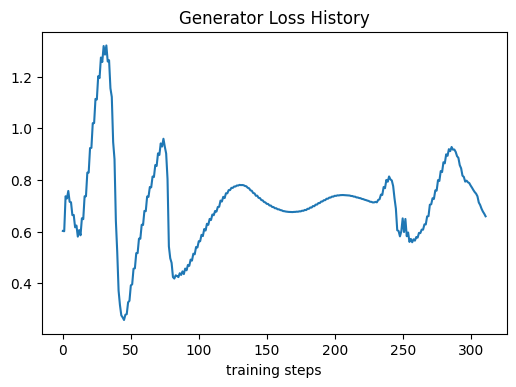

In [74]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

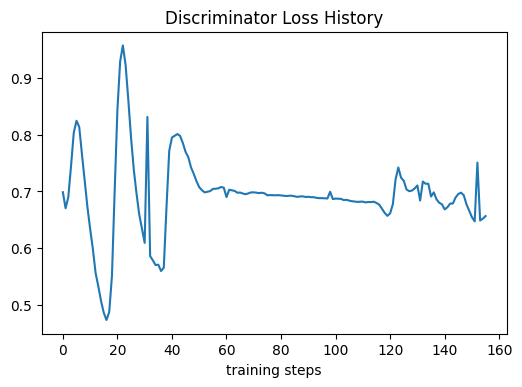

In [73]:

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('training steps')

In [78]:
G0 = build_G(batch_size=BATCH_SIZE, seq_length=T, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM)

G2 = G

In [79]:
z = np.float32(np.random.normal(size=[BATCH_SIZE, T, LATENT_DIM]))
G2(z)

<tf.Tensor: shape=(256, 20, 1), dtype=float32, numpy=
array([[[-0.11187293],
        [-0.22788005],
        [-0.00102461],
        ...,
        [ 0.05429771],
        [-0.35168523],
        [-0.24617822]],

       [[-0.24046192],
        [-0.18075684],
        [-0.14890137],
        ...,
        [-0.08441966],
        [-0.14262506],
        [-0.16034356]],

       [[-0.21134427],
        [-0.17313868],
        [-0.14223929],
        ...,
        [-0.19191837],
        [-0.04020587],
        [-0.04673288]],

       ...,

       [[-0.16234645],
        [-0.08490358],
        [-0.04763082],
        ...,
        [-0.11541191],
        [ 0.0339409 ],
        [-0.28663778]],

       [[-0.20192966],
        [ 0.00995448],
        [-0.01683194],
        ...,
        [-0.03958438],
        [-0.1895127 ],
        [-0.24992537]],

       [[-0.22772217],
        [-0.28243193],
        [ 0.1845355 ],
        ...,
        [ 0.2019063 ],
        [ 0.04899137],
        [-0.04260484]]], dtype=float32)>

In [80]:
if not os.path.exists(model_save_dir + '/trained_G_weights'):
    os.makedirs(model_save_dir + '/trained_G_weights')

G_save_path = model_save_dir + '/trained_G_weights/model.tf'
G.save_weights(G_save_path)

if not os.path.exists(model_save_dir + '/trained_D_weights'):
    os.makedirs(model_save_dir + '/trained_D_weights')

D_save_path = model_save_dir + '/trained_D_weights/model.tf'
D.save_weights(D_save_path)